## Recurrent event: Exploratory Data Analysis

- This notebook dedicated to understanding the recurrent event process
- We compute time-until-first reported event for
    + End-of-Day (EOD) EMA
    + Self-report
    + Random EMA
    + puffMarker
- We combine SR and EMA as these are meant to be non-overlapping
- We see that each source is not perfect and so combining provides important additional information
- We see that people lapse very quickly with the # of smoking episodes after the first lapse increases quickly day-by-day
- TODO: Want to show that self-report is insufficient by itself

In [149]:
# Import packages and set directory
import pandas as pd
import numpy as np
import datetime as datetime
import os
print(os.getcwd())
dir = "../final-data"

/home/wdempsey/Documents/github/sense2stop-lvm/exploratory_data_analysis


In [150]:
# Response windows for end-of-day EMA
keys = ['8to9', '9to10', '10to11', '11to12',
        '12to13','13to14','14to15','15to16',
        '16to17','17to18','18to19','19to20']

In [151]:
# read EOD data and participant entry/exit dates
eod_ema = pd.read_csv(os.path.join(os.path.realpath(dir), 'eod-ema-final.csv'))
participant_dates = pd.read_csv(os.path.join(os.path.realpath(dir),'participant-dates-v3.csv'))

In [152]:
# Construct user-days and record how many cigarettes
# are reported in the EOD EMA
eod_dates = []
for irow in range(0,eod_ema.shape[0]):
    row = eod_ema.iloc[irow]
    quit_iloc = np.where(participant_dates['participant'] == row['participant_id'])
    quit_row = participant_dates.iloc[quit_iloc[0][0]]
    quit_time = datetime.datetime.strptime(quit_row['quit_date'], '%m/%d/%y')
    if row['status'] == "MISSED":
        continue
    try:
        time = datetime.datetime.strptime(row['date'], '%m/%d/%Y %H:%M')
    except:
        time = datetime.datetime.strptime(row['date'], '%Y-%m-%d %H:%M:%S')
    #print row['participant_id'], time
    #print quit_row['participant'], quit_time
    temp_diff = time - quit_time
    if time.hour  == 0 or time.hour == 1:
        date = np.array([row['participant_id'], temp_diff.days-1])
        date = np.append(date, np.sum(np.array(row[keys])))
    else:
        date = np.array([row['participant_id'], temp_diff.days])
        date = np.append(date, np.sum(np.array(row[keys])))
    #print date
    eod_dates.append(date)
    
eod_dates = np.asarray(eod_dates)
eod_dates

array([[201.,  -3.,   2.],
       [201.,  -2.,   9.],
       [203.,   6.,   0.],
       ...,
       [269.,   8.,   0.],
       [269.,   9.,   0.],
       [269.,  10.,   0.]])

In [153]:
## Each day get the mean and standard deviation
## in the number of reported cigarettes using end-of-day EMA
for day in range(-3, 11):
    print(day, np.round(np.nanmean(eod_dates[eod_dates[:,1] == day,2]),3), np.round(np.nanstd(eod_dates[eod_dates[:,1] == day,2]),3))

(-3, 4.444, 2.948)
(-2, 4.812, 3.193)
(-1, 4.227, 2.867)
(0, 1.7, 2.015)
(1, 1.237, 1.286)
(2, 1.735, 2.429)
(3, 1.324, 2.529)
(4, 1.176, 2.022)
(5, 1.629, 2.294)
(6, 1.424, 2.118)
(7, 1.839, 2.554)
(8, 1.735, 1.975)
(9, 1.676, 2.665)
(10, 2.0, 3.215)


In [154]:
eod_survival = []
for id in np.unique(eod_dates[:,0]):
    subset = eod_dates[eod_dates[:,0] == id,:]
    if any(subset[:,1] > 0):
        subset = subset[subset[:,1] > 0,:]
        nonzero_iloc = np.where(subset[:,2] > 0)[0]
        zero_iloc = np.where(subset[:,2] == 0)[0]
        if len(nonzero_iloc) == 0:
            if len(zero_iloc) != 0:
                temp = np.append(subset[np.max(zero_iloc),0:2], 0)
        else:
            temp = np.append(subset[np.min(nonzero_iloc), 0:2], 1)
        eod_survival.append(temp)

eod_survival = np.asarray(eod_survival)
eod_survival

array([[203.,  10.,   0.],
       [205.,   8.,   1.],
       [206.,   9.,   0.],
       [207.,   1.,   1.],
       [208.,   1.,   1.],
       [211.,   2.,   1.],
       [214.,   1.,   1.],
       [215.,   1.,   1.],
       [216.,   5.,   1.],
       [217.,   1.,   1.],
       [218.,  10.,   0.],
       [219.,   1.,   1.],
       [222.,   1.,   1.],
       [223.,  10.,   0.],
       [224.,   1.,   1.],
       [225.,   1.,   1.],
       [226.,   1.,   1.],
       [227.,   1.,   1.],
       [228.,   1.,   1.],
       [229.,   2.,   1.],
       [230.,   1.,   1.],
       [231.,   1.,   1.],
       [233.,   1.,   1.],
       [234.,   1.,   1.],
       [235.,   3.,   0.],
       [238.,   1.,   1.],
       [240.,   4.,   1.],
       [242.,   8.,   1.],
       [244.,   9.,   0.],
       [245.,   5.,   1.],
       [247.,   1.,   1.],
       [248.,  10.,   0.],
       [249.,   1.,   1.],
       [250.,  10.,   0.],
       [251.,   9.,   0.],
       [252.,   1.,   1.],
       [253.,   4.,   1.],
 

In [7]:
# Read data for self-report
selfreport = pd.read_csv(os.path.join(os.path.realpath(dir), 'self-report-smoking-final.csv'))

In [8]:
'''
Extract all smoking events and label with correct user-day
'''

sr_dates = []
for irow in range(0,selfreport.shape[0]):
    row = selfreport.iloc[irow]
    quit_iloc = np.where(participant_dates['participant'] == row['participant_id'])
    quit_row = participant_dates.iloc[quit_iloc[0][0]]
    quit_time = datetime.datetime.strptime(quit_row['quit_date'], '%m/%d/%y')
    try:
        time = datetime.datetime.strptime(row['date'], '%m/%d/%y %H:%M')
    except:
        time = datetime.datetime.strptime(row['date'], '%Y-%m-%d %H:%M:%S')
    temp_diff = time - quit_time
    if time.hour  == 0 or time.hour == 1:
        date = np.array([row['participant_id'], temp_diff.days-1])
    else:
        date = np.array([row['participant_id'], temp_diff.days])
    sr_dates.append(date)
    
sr_dates = np.asarray(sr_dates)

In [9]:
'''
Aggregate smoking events for each user-day
'''

sr_pd = pd.DataFrame(sr_dates)
sr_pd.columns = ['user', 'day']
sr_userdays = sr_pd.groupby(['user','day']).size().reset_index()
sr_userdays.columns = ['user', 'day', 'smoke']

sr_userdays.groupby('day')['smoke'].mean()

day
-4     2.500000
-3     4.380952
-2     7.210526
-1     6.056604
 0     3.000000
 1     2.476190
 2     3.578947
 3     4.000000
 4     5.153846
 5     5.307692
 6     5.833333
 7     5.571429
 8     6.076923
 9     3.800000
 10    5.642857
 11    2.000000
Name: smoke, dtype: float64

In [156]:
'''
For each user, find the first user-day on which 
they self-reported smoking
''' 

sr_survival = []
for id in np.unique(sr_dates[:,0]):
    subset = sr_dates[sr_dates[:,0] == id,:]
    if any(subset[:,1] > 0):
        subset = subset[subset[:,1] > 0,:]
        temp = [id, np.min(subset[:,1])]
        sr_survival.append(temp)

sr_survival = np.asarray(sr_survival)

array([[202,   2],
       [207,   1],
       [208,   1],
       [211,   2],
       [212,   8],
       [214,   2],
       [215,   1],
       [216,   7],
       [217,   3],
       [218,   1],
       [219,   1],
       [224,   1],
       [226,   1],
       [227,   1],
       [228,   2],
       [229,   2],
       [231,   1],
       [233,   1],
       [238,   3],
       [240,   1],
       [241,   1],
       [243,   5],
       [247,   1],
       [249,   1],
       [252,   1],
       [253,   5],
       [254,   1],
       [255,   4],
       [256,   4],
       [259,   3],
       [261,   1],
       [262,   1],
       [263,   2],
       [264,   1],
       [265,   2],
       [266,   1],
       [267,   1]])

In [11]:
# Read data for random EMA
random_ema = pd.read_csv(os.path.join(os.path.realpath(dir),'random-ema-final.csv'))

In [12]:
'''
Extract all smoking events from random EMA and label with correct user-day
'''

random_dates = []
for irow in range(0,random_ema.shape[0]):
    row = random_ema.iloc[irow]
    quit_iloc = np.where(participant_dates['participant'] == row['participant_id'])
    quit_row = participant_dates.iloc[quit_iloc[0][0]]
    quit_time = datetime.datetime.strptime(quit_row['quit_date'], '%m/%d/%y')
    if row['status'] == "MISSED":
        continue
    try:
        time = datetime.datetime.strptime(row['date'], '%m/%d/%y %H:%M')
    except:
        time = datetime.datetime.strptime(row['date'], '%Y-%m-%d %H:%M:%S')
    #print row['participant_id'], time
    #print quit_row['participant'], quit_time
    temp_diff = time - quit_time
    if time.hour  == 0 or time.hour == 1:
        date = np.array([row['participant_id'], temp_diff.days-1])
        if row['smoke'] == 'Yes':
            date = np.append(date, [1])
            random_dates.append(date)
        if row['smoke'] == 'No':
            date = np.append(date, [0])
            random_dates.append(date)
    else:
        date = np.array([row['participant_id'], temp_diff.days])
        if row['smoke'] == 'Yes':
            date = np.append(date, 1)
            random_dates.append(date)
        if row['smoke'] == 'No':
            date = np.append(date, 0)
            random_dates.append(date)

random_dates = np.asarray(random_dates)

In [66]:
'''
Aggregate smoking events for each user-day
within the random EMA
'''

random_pd = pd.DataFrame(random_dates)
random_pd.columns = ['user', 'day', 'smoke']
random_userdays = random_pd.groupby(['user','day'])['smoke'].sum().reset_index()

In [148]:
random_survival = []
for id in np.unique(random_dates[:,0]):
    iloc = np.where((random_userdays['user'] == id) & (random_userdays['day'] > 0))
    subset = random_userdays.iloc[iloc]
    if any(subset['smoke'] > 0):
        nonzero_iloc = np.where(subset['smoke'] > 0)
        zero_iloc = np.where(subset['smoke'] == 0)
        if np.size(nonzero_iloc) == 0:
            if np.size(zero_iloc) != 0:
                temp = np.append(subset.loc[iloc[0][np.max(zero_iloc)], ['user', 'day']], 0)
        else:
            temp = np.append(subset.loc[iloc[0][np.min(nonzero_iloc)], ['user','day']], 1)
        random_survival.append(temp)

random_survival = np.asarray(random_survival)

array([[202,   1,   1],
       [205,   8,   1],
       [208,   1,   1],
       [211,   8,   1],
       [212,   3,   1],
       [214,   4,   1],
       [216,   7,   1],
       [217,   1,   1],
       [218,   1,   1],
       [219,   1,   1],
       [222,   1,   1],
       [224,   1,   1],
       [225,   1,   1],
       [226,   2,   1],
       [227,   1,   1],
       [228,   8,   1],
       [229,   2,   1],
       [231,   2,   1],
       [233,   1,   1],
       [238,   1,   1],
       [240,   3,   1],
       [241,   1,   1],
       [245,   2,   1],
       [247,   1,   1],
       [252,   1,   1],
       [253,   5,   1],
       [254,   1,   1],
       [255,  10,   1],
       [258,   2,   1],
       [259,   3,   1],
       [260,   1,   1],
       [261,   3,   1],
       [262,   1,   1],
       [265,   6,   1],
       [267,   1,   1],
       [269,   3,   1]])

In [16]:
# Read data for puffMarker
puffMarker = pd.read_csv(os.path.join(os.path.realpath(dir),'puff-episode-final.csv'))

In [17]:
'''
Extract all smoking events from puffMarker and label with correct user-day
'''

pM_dates = []
for irow in range(0,puffMarker.shape[0]):
    row = puffMarker.iloc[irow]
    quit_iloc = np.where(participant_dates['participant'] == row['participant_id'])
    quit_row = participant_dates.iloc[quit_iloc[0][0]]
    quit_time = datetime.datetime.strptime(quit_row['quit_date'], '%m/%d/%y')
    try:
        time = datetime.datetime.strptime(row['date'], '%m/%d/%y %H:%M')
    except:
        time = datetime.datetime.strptime(row['date'], '%Y-%m-%d %H:%M:%S')
    #print row['participant_id'], time
    #print quit_row['participant'], quit_time
    temp_diff = time - quit_time
    if time.hour  == 0 or time.hour == 1:
        date = np.array([row['participant_id'], temp_diff.days-1])
        date = np.append(date, [1])
        pM_dates.append(date)
    else:
        date = np.array([row['participant_id'], temp_diff.days])
        date = np.append(date, 1)
        pM_dates.append(date)
        
pM_dates = np.asarray(pM_dates)

In [18]:
'''
Aggregate smoking events for each user-day
within the puffMarker
'''

pM_pd = pd.DataFrame(pM_dates)
pM_pd.columns = ['user', 'day', 'smoke']
pM_pd_userdays = pM_pd.groupby(['user','day'])['smoke'].sum().reset_index()

In [157]:
pM_survival = []
for id in np.unique(pM_dates[:,0]):
    subset = pM_dates[pM_dates[:,0] == id,:]
    if any(subset[:,1] > 0):
        subset = subset[subset[:,1] > 0,:]
        nonzero_iloc = np.where(subset[:,2] == 1)[0]
        zero_iloc = np.where(subset[:,2] == 0)[0]
        if len(nonzero_iloc) == 0:
            if len(zero_iloc) != 0:
                temp = np.append(subset[np.max(zero_iloc),0:2], 0)
        else:
            temp = np.append(subset[np.min(nonzero_iloc), 0:2], 1)
        pM_survival.append(temp)

pM_survival = np.asarray(pM_survival)

In [159]:
all_ema_survival = np.array([])
sr_random_survival = np.array([])

for id in np.unique(np.concatenate([random_survival[:,0], sr_survival[:,0], eod_survival[:,0]])):
    temp = np.array([id])
    random_subset = random_survival[random_survival[:,0] == id,:]
    if not len(random_subset) == 0:
        temp = np.append(temp, random_subset[0][1:3])
    else:
        temp = np.append(temp, [-1,-1]) 
    sr_subset = sr_survival[sr_survival[:,0] == id,:]
    if not len(sr_subset) == 0:
        sr_day = sr_subset[0][1]
        if temp[1] > sr_day or temp[1] == -1:
            temp[1:3] = [sr_day,1]
    temp2 = temp
    sr_random_survival = np.append(sr_random_survival, temp2)
    eod_subset = eod_survival[eod_survival[:,0] == id, :]
    if not len(eod_subset) == 0:
        if eod_subset[0][1] < temp[1] and eod_subset[0][2] == 1:
            temp[1:3] = eod_subset[0][1:3]
        elif eod_subset[0][1] > temp[1] and eod_subset[0][2] == 0 and temp[2] == 0:
            temp[1:3] = eod_subset[0][1:3]
    all_ema_survival = np.append(all_ema_survival, temp)

sr_random_survival = np.reshape(sr_random_survival, (-1,3))
all_ema_survival = np.reshape(all_ema_survival, (-1,3))

In [180]:
def km_estimation(day_range, survival_data):
    km_list = [1]
    var_list = [0]
    for day in day_range:
        n_day = np.sum(survival_data[:,1] >= day, dtype='f')
        subset = survival_data[survival_data[:,1] == day,:]
        subset = subset[subset[:,2] == 1]
        d_day = subset.shape[0]
        if n_day > 0 and n_day > d_day:
            km_list.append(1-d_day/n_day)
            var_list.append(d_day/(n_day * (n_day - d_day)))
        else:
            km_list.append(0)
            var_list.append(0)

    km_est = np.cumprod(km_list)

    var_est = np.multiply(np.power(km_est,2),np.cumsum(var_list))

    km_stderr = np.sqrt(var_est)

    upper_km_est = km_est + 1.96*km_stderr
    lower_km_est = km_est - 1.96*km_stderr
    return(lower_km_est, km_est, upper_km_est)

In [181]:
'''
Fit Kaplan-Meier curves for (1) All EMA, (2) Only EOD, (3) Only SR and Random, and (4) Only puffMarker
'''

day_range = range(1,12)

lower_km_est, km_est, upper_km_est = km_estimation(day_range, all_ema_survival)

eod_lower_km_est, eod_km_est, eod_upper_km_est = km_estimation(day_range, eod_survival)

sr_random_lower_km_est, sr_random_km_est, sr_random_upper_km_est = km_estimation(day_range, sr_random_survival)

pM_lower_km_est, pM_km_est, pM_upper_km_est = km_estimation(day_range, pM_survival)

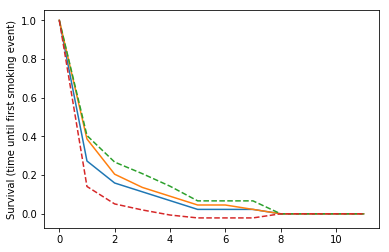

In [186]:
import matplotlib.pyplot as plt
plt.plot(km_est)
# plt.plot(eod_km_est)
plt.plot(sr_random_km_est)
# plt.plot(pM_km_est)
plt.plot(upper_km_est,linestyle='dashed')
plt.plot(lower_km_est,linestyle='dashed')
plt.ylabel('Survival (time until first smoking event)')
plt.show()

In [175]:
'''
Combine self-report and random to get a user-day total count
'''
sr_random_userdays = pd.merge(random_pd_userdays, sr_userdays, on=['user', 'day'])
sr_random_userdays['total_smoke'] = sr_random_userdays['smoke_x'] + sr_random_userdays['smoke_y']
sr_random_userdays.groupby('day')['total_smoke'].mean()

day
-4     3.500000
-3     4.982456
-2     8.125000
-1     6.884615
 0     3.812500
 1     3.421053
 2     4.333333
 3     5.153846
 4     6.100000
 5     5.923077
 6     7.000000
 7     6.428571
 8     7.000000
 9     4.357143
 10    6.916667
 11    2.000000
Name: total_smoke, dtype: float64

In [241]:
'''
Here we use all_ema_survival to define the first-event.  Then we compute daily totals
for next few days
'''

day_since_cig = np.array([])
sr_subset = sr_random_userdays.iloc[np.where(sr_random_userdays['day'] > 0)]
unique_users = np.unique(sr_subset['user'])
for id in unique_users:
    first_day_smoking_post_quit = all_ema_survival[all_ema_survival[:,0] == id,1]
    subset = sr_subset.iloc[np.where(sr_subset['user'] == id)]
    temp = subset['day'] - first_day_smoking_post_quit
    day_since_cig = np.append(day_since_cig, temp)

x = day_since_cig.flatten()
sr_subset['day_since_first_smoke'] = x

sr_subset.groupby(['day_since_first_smoke'])['total_smoke'].mean().reset_index()


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,day_since_first_smoke,total_smoke
0,0.0,3.440000
1,1.0,4.437500
2,2.0,5.230769
3,3.0,5.833333
4,4.0,5.769231
5,5.0,5.928571
6,6.0,7.076923
7,7.0,8.666667
8,8.0,4.461538
9,9.0,7.333333
